# Comparison to Semi-Supervised Inference

The goal of this experiment is to compare prediction-powered inference and the semi-supervised mean estimation algorithm of Zhang and Bradic (1). Their procedure involves cross-fitting a (possibly-regularized) linear model on $K$ distinct folds of the gold-standard data set. The average of the $K$ model predictions on each unlabeled data point is taken as its corresponding $\hat{Y}'$, and the average bias $\hat{Y}-Y$ of the $K$ models is also computed and used to debias the resulting mean estimate.

The inferential goal is to estimate the mean income in California in the year 2019 among employed individuals. The same data is used in the notebook [```census_income.ipynb```](https://github.com/aangelopoulos/ppi_py/blob/main/examples/census_income.ipynb).


1. Y. Zhang, J. Bradic, High-dimensional semi-supervised learning: in search of optimal inference of the mean. Biometrika 109(2), 387–403 (2022).

### Import necessary packages

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys

sys.path.append(
    os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
)
import numpy as np
import pandas as pd
from ppi_py.datasets import load_dataset
from ppi_py import ppi_mean_ci, semisupervised_mean_ci, classical_mean_ci
from tqdm import tqdm
from scipy.optimize import brentq
from baseline_utils import *

### Import the census income data set

Load the data. The data set contains reported income (```Y```), predicted income (```Yhat```), and age and sex (```X```).

In [2]:
dataset_folder = "../data/"
data = load_dataset(dataset_folder, "census_income")
Y_total = data["Y"]
Yhat_total = data["Yhat"]
X_total = data["X"]

### Problem setup

Specify the error level (```alpha```), range of values for the labeled data set size (```ns```), and number of trials (```num_trials```).

Compute the ground-truth value of the estimand.

In [3]:
alpha = 0.1
n_total = Y_total.shape[0]  # Total number of labeled examples
ns = np.linspace(50, 1000, 10).astype(
    int
)  # Test for different numbers of labeled examples
num_trials = 50
K = 5  # Folds for semisupervised

# True mean (computed on all labels)
true_theta = Y_total.mean()

### Construct intervals

Form confidence intervals for all methods and problem parameters. A dataframe with the following columns is formed:
1. ```method``` (one of ```PPI```, ```Classical```, and ```Baseline```, where ```Baseline``` is the semi-supervised inference baseline)
2. ```n``` (labeled data set size, takes values in ```ns```)
3. ```lower``` (lower endpoint of the confidence interval)
4. ```upper``` (upper endpoint of the confidence interval)
5. ```trial``` (index of trial, goes from ```0``` to ```num_trials-1```)

In [4]:
# Run prediction-powered inference and classical inference for many values of n
results = []
for i in tqdm(range(ns.shape[0])):
    for j in range(num_trials):
        # Prediction-Powered Inference
        n = ns[i]
        rand_idx = np.random.permutation(n_total)
        _Yhat = Yhat_total[rand_idx[:n]]
        _Y = Y_total[rand_idx[:n]]
        _X = X_total[rand_idx[:n]]
        _X_unlabeled = X_total[rand_idx[n:]]
        _Yhat_unlabeled = Yhat_total[rand_idx[n:]]

        # PPI interval
        ppi_ci = ppi_mean_ci(_Y, _Yhat, _Yhat_unlabeled, alpha=alpha)

        # Semisupervised interval
        semisupervised_ci = semisupervised_mean_ci(
            _X, _Y, _X_unlabeled, K, alpha=alpha
        )

        # Classical interval
        classical_ci = classical_mean_ci(_Y, alpha=alpha)

        # Append results
        results += [
            pd.DataFrame(
                [
                    {
                        "method": "PPI",
                        "n": n,
                        "lower": ppi_ci[0],
                        "upper": ppi_ci[1],
                        "trial": j,
                    }
                ]
            )
        ]

        results += [
            pd.DataFrame(
                [
                    {
                        "method": "Baseline",  # Semisupervised baseline
                        "n": n,
                        "lower": semisupervised_ci[0],
                        "upper": semisupervised_ci[1],
                        "trial": j,
                    }
                ]
            )
        ]

        results += [
            pd.DataFrame(
                [
                    {
                        "method": "Classical",
                        "n": n,
                        "lower": classical_ci[0],
                        "upper": classical_ci[1],
                        "trial": j,
                    }
                ]
            )
        ]

df = pd.concat(results, axis=0, ignore_index=True)
df["width"] = df["upper"] - df["lower"]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:02<00:00, 12.26s/it]


### Plot results

Plot:
1. Five randomly chosen intervals from the dataframe for PPI, classical inference, and the semi-supervised inference baseline;
2. The average interval width for PPI, classical inference, and the semi-supervised inference baseline. 

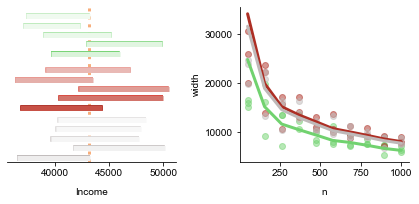

In [5]:
make_plots(
    df,
    "./plots/semisupervised_census_income.pdf",
    n_idx=-1,
    intervals_xlabel="Income",
    true_theta=true_theta,
)

### Power experiment

For PPI, classical inference, and semi-supervised inference, find the smallest value of ```n``` such that the method has power 80% against the null $H_0: \text{mean income} \leq 30K$.

In [6]:
# Find n such that we reject H0: income < 30K with probability 80% using a test at level alpha
num_experiments = 100
list_rand_idx = [
    np.random.permutation(n_total) for i in range(num_experiments)
]


def _to_invert_ppi(n):
    n = int(n)
    nulls_rejected = 0
    # Data setup
    for i in range(num_experiments):
        rand_idx = list_rand_idx[i]
        _Yhat = Yhat_total[rand_idx[:n]]
        _Y = Y_total[rand_idx[:n]]
        _Yhat_unlabeled = Yhat_total[rand_idx[n:]]

        ppi_ci = ppi_mean_ci(_Y, _Yhat, _Yhat_unlabeled, alpha=0.05)
        if ppi_ci[0] > 30000:
            nulls_rejected += 1
    return nulls_rejected / num_experiments - 0.8


def _to_invert_semisupervised(n):
    n = int(n)
    nulls_rejected = 0
    # Data setup
    for i in range(num_experiments):
        rand_idx = list_rand_idx[i]
        _Y = Y_total[rand_idx[:n]]
        _X = X_total[rand_idx[:n]]
        _X_unlabeled = X_total[rand_idx[n:]]

        semisupervised_ci = semisupervised_mean_ci(
            _X, _Y, _X_unlabeled, K, alpha=0.05
        )

        if semisupervised_ci[0] > 30000:
            nulls_rejected += 1
    return nulls_rejected / num_experiments - 0.8


def _to_invert_classical(n):
    n = int(n)
    nulls_rejected = 0
    # Data setup
    for i in range(num_experiments):
        rand_idx = list_rand_idx[i]
        _Y = Y_total[rand_idx[:n]]

        classical_ci = classical_mean_ci(_Y, alpha=0.05)

        if classical_ci[0] > 30000:
            nulls_rejected += 1
    return nulls_rejected / num_experiments - 0.8

In [7]:
n_ppi = int(brentq(_to_invert_ppi, 1, 5000, xtol=1))
n_semisupervised = int(brentq(_to_invert_semisupervised, 1, 5000, xtol=1))
n_classical = int(brentq(_to_invert_classical, 1, 5000, xtol=1))
print(
    f"The PPI test requires n={n_ppi} labeled data points to reject the null."
)
print(
    f"The semisupervised test requires n={n_semisupervised} labeled data points to reject the null."
)
print(
    f"The classical test requires n={n_classical} labeled data points to reject the null."
)

/Users/angelopoulos/Code/working/ppi_py/ppi_py/baselines.py:66: RuntimeWarning: Mean of empty slice.
  * (beta_fold.dot(Vhat_fold.T) * epsilon_hats[fold_indices]).mean()
/Users/angelopoulos/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/angelopoulos/Code/working/ppi_py/ppi_py/baselines.py:69: RuntimeWarning: Mean of empty slice.
  2 * beta_fold.dot(Vhat_fold.T).mean()


The PPI test requires n=120 labeled data points to reject the null.
The semisupervised test requires n=208 labeled data points to reject the null.
The classical test requires n=201 labeled data points to reject the null.
